# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given its image. For example, when I'm sitting at a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evalutation

Evaluation are based on a Multi-Class Log Loss. The evaluation is a file with prediction probabilities for each dog breed for each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview

## 4. Features

Some information about the data:
* We're dealing with images (Unstructured Data) so it's probably best we use Deep Learning / Transfer Learning.
* There are 120 breeds of dogs (This means there are 120 different classes, therefore multi-class classification.)
* Training Data Points (10,200 Images). These images have labels.
* Test Data Points (10,200 Images). These images have no labels, because we'll want to predict them.

In [ ]:
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Getting our workspace ready

* Import TensorFlow 2.13.0 ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅


In [ ]:
# Import TensorFlow & TensorFlow Hub into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF-Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available: (YESSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not unavailable :(")

TF version: 2.13.0
TF-Hub version: 0.14.0
GPU available: (YESSSS!!!!)


A TensorFlow Workflow:

1. Get data ready. (Turn data into tensors AKA a matrix)
2. Pick a model (To suit your problem)
3. Fit the model to the data & make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save & reload your trained model

## Getting our data ready (Turning our data into Tensors)

With all machine learning models, our data has to be in numerical formate. So that's what we'll be doing first. Turning our images into Tensors (Numerical Representations).

Let's start by accessing our data and check out the labels.

In [ ]:
# Check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

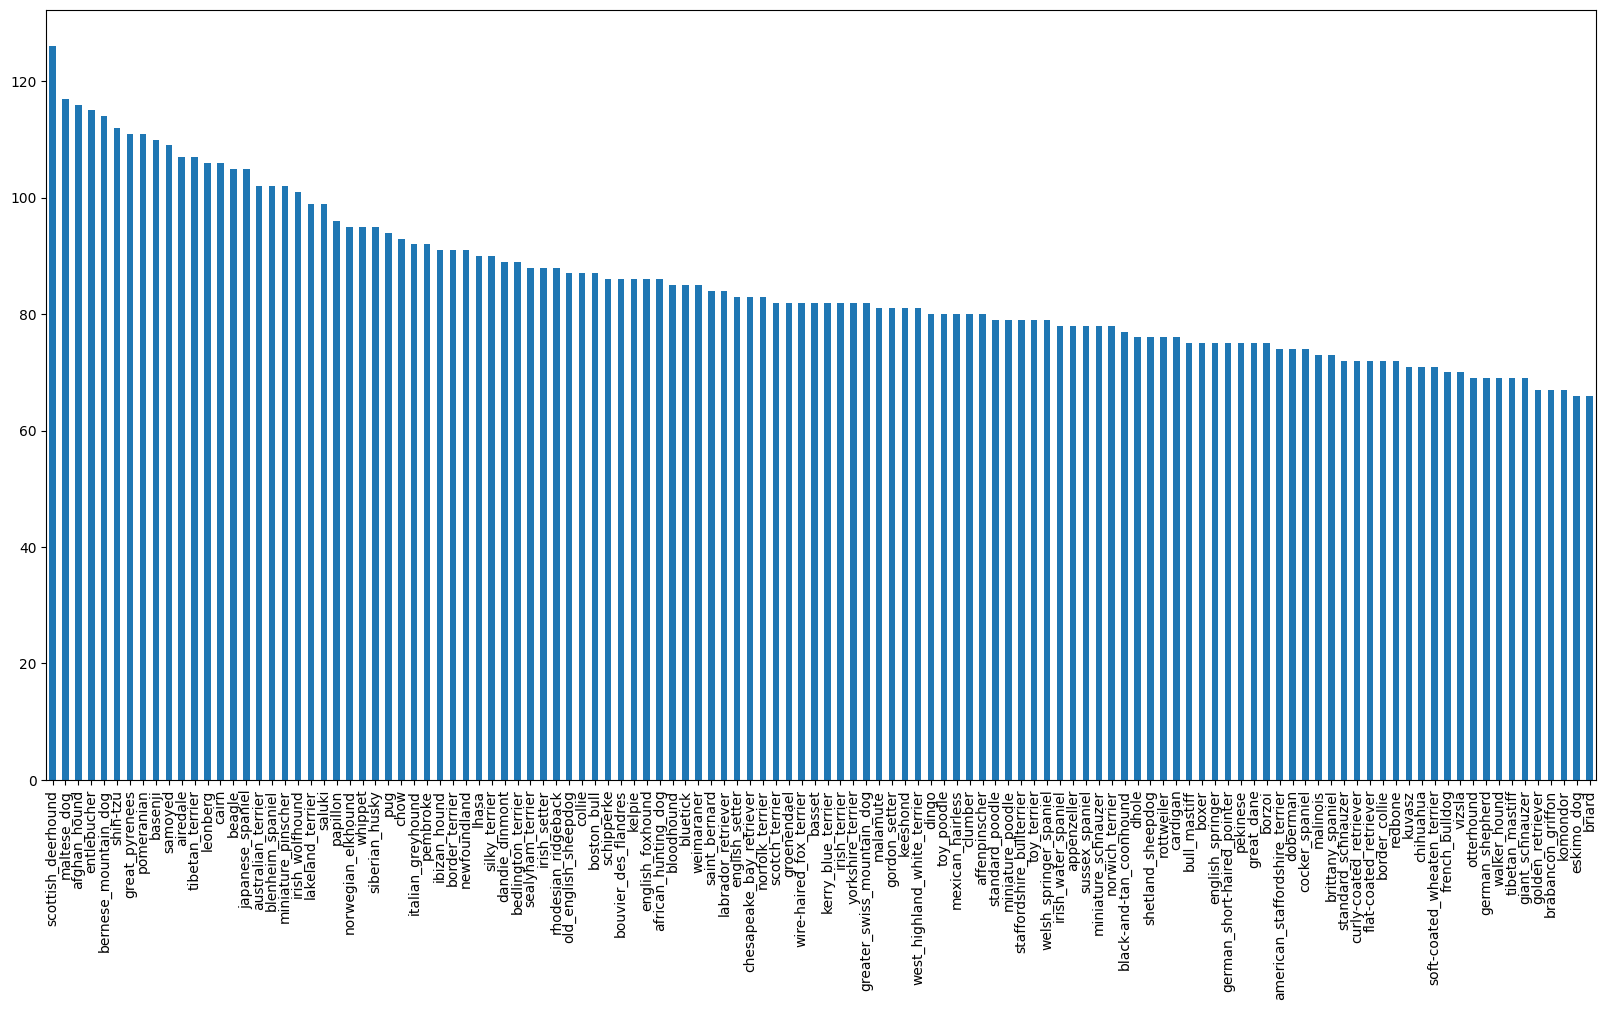

In [ ]:
# How many images per class?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

This is good! 100 per class is great and the minimum required is 10 per class

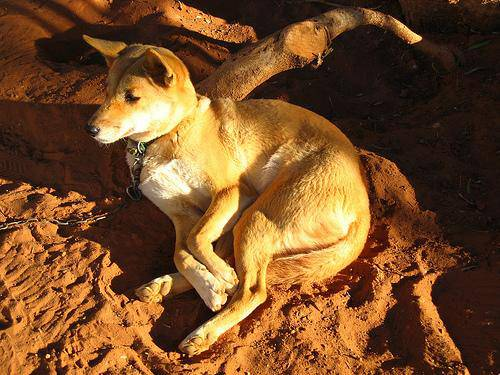

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames

In [ ]:
# Create a list of pathnames of Image ID's
filenames = ["drive/My Drive/Dog Vision/dog-breed-identification/train/"+ fname for fname in labels_csv["id"]+ ".jpg"]

filenames[:5]

['drive/My Drive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if ((len(os.listdir("drive/MyDrive/Dog Vision/dog-breed-identification/train/"))) == (len(filenames))):
  print("It's a match!")
else:
  print("Sorry! It's not a match.")

It's a match!


In [ ]:
len(filenames), len(os.listdir("drive/MyDrive/Dog Vision/dog-breed-identification/train/"))

(10222, 10222)

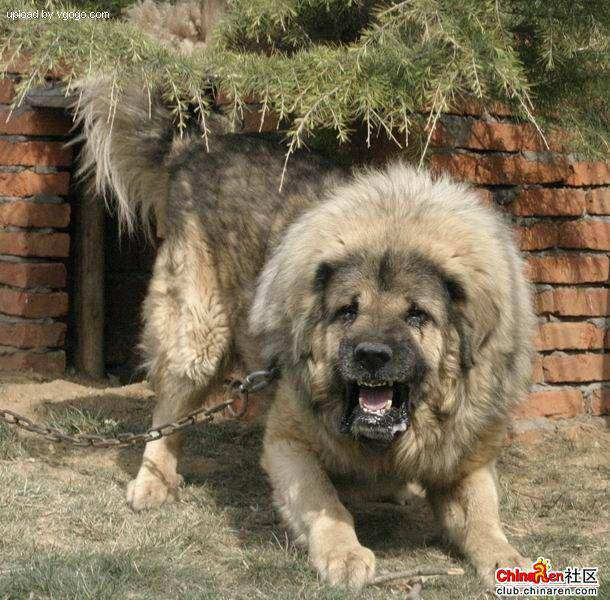

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)


120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # Original Label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# Set X & y
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase it from there.

In [ ]:
# Set number of samples to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}


In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation fo total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

### Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input.
2. Use TensorFlow to read the file and save it to a variable,`image`.
3. Turn our `image` (a jpg) into Tensors
4. Normalise our image (Convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [ ]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Let's build our function
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image filepath and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the image into numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (Called Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
tensor = tf.io.read_file(filenames[20])

In [ ]:
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [ ]:
smtin = tf.image.convert_image_dtype(tensor, tf.float32)

## Turning data into batches (Tensor likes seeing data in a data batch)
### What is a good batch size? Apparently 32...

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 images at a time (You can manually adjust the batch size need be.)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this (`image`, `label`)

In [ ]:
# Create a simple function to return a tuple of tensors (image, labels)
def get_image_label(image_path, label):
  """
  Takes an `image` file path name and the associated label, processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (X & y) into batches!

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising Data Batches

Our data is now in batches, however, these can be a little hard to understand, let's visualise them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [ ]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# train_images, train_labels

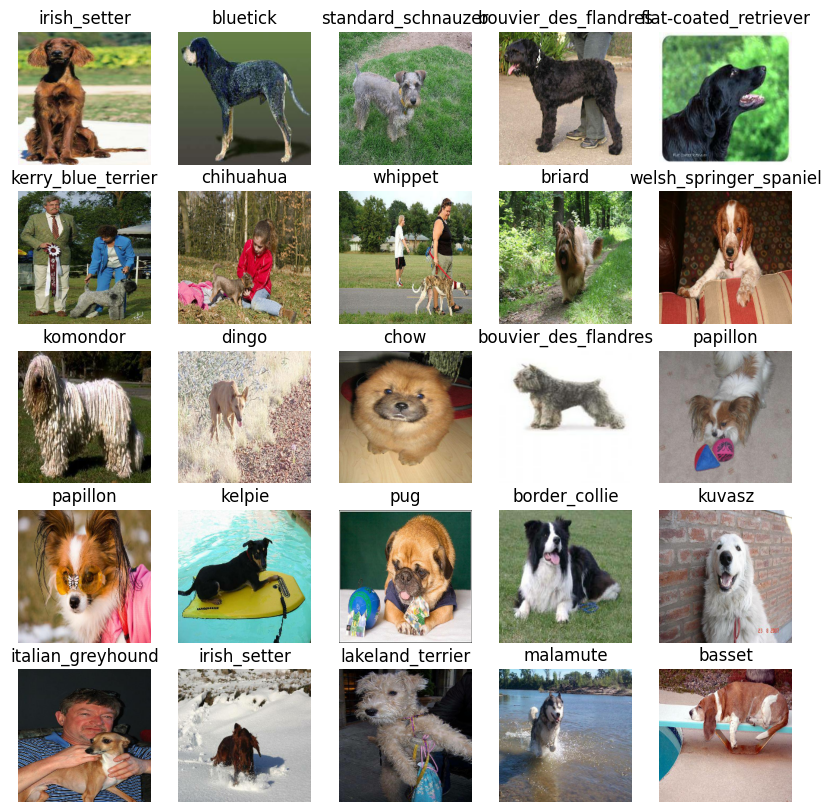

In [ ]:
# Let's visualise the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [ ]:
len(train_images), len(train_labels)

(32, 32)

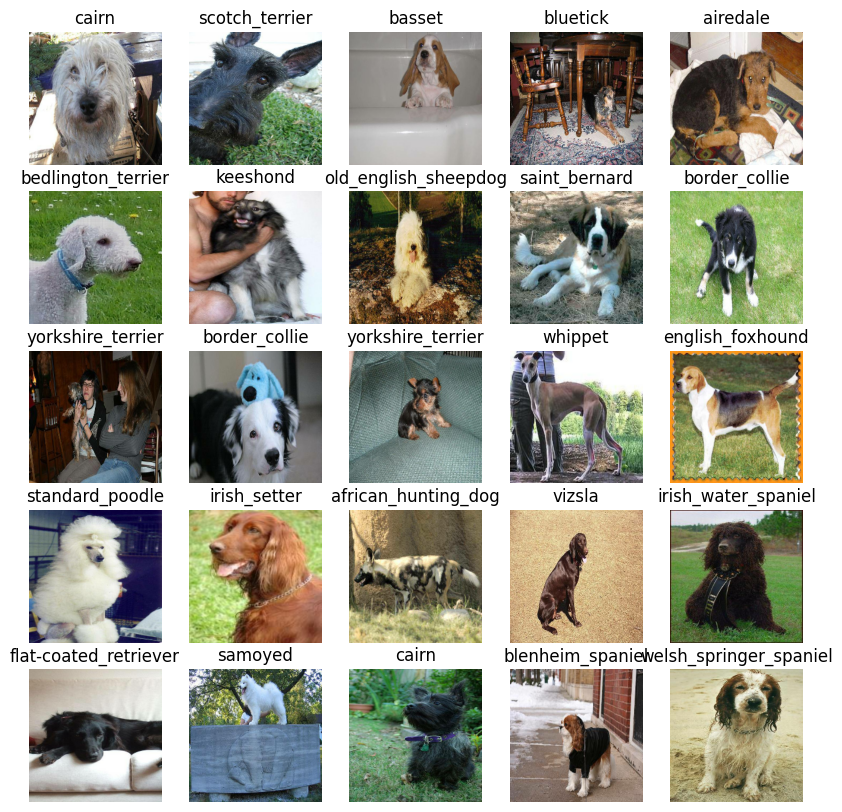

In [ ]:
# Now let's visualise our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our models.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got out inputs, outputs and model ready to go.

Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (Do this first, then this, then that)
* Compiles the model (says how it should be evaulated and improved)
* Builds the model (tels the model the input shape it'll be getting)
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [ ]:
# Create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Input layer
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_4 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
outputs = np.ones(shape=(1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save its progress, check it progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our models from training too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard Notebook Extension ✅
2. Create a TensorBoard callback which is able to save logs to a dictionary and pass it our model's `fit()` function. ✅
3. Visualise our models training logs with the %tensorboard magic function (We'll do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  """
  Create a log dictionary for storing TensorBoard logs
  """
  logdir = os.path.join("/content/drive/MyDrive/Dog Vision/dog-breed-identification/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

 ## Training a model (on a subset of data)

 Our first model is only going to train on a 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step: 10}

EPOCS: No of passes of data we'd like our model to do.

We begin by starting on a subset of the data to make sure all of this code, I mean, it might break.

So we want to make sure that it's working before we spend a long time training on 10,000 images because

training on a thousand images is going to go a lot faster than 10,000 images.

And you could imagine the same goes if you increase it to 100,000 images.

So there's one more variable that we have to define.

Before we can get into training a model and that is number of epochs.

And so the number of epochs is how many passes of the data we'd like our model to do.

And a pass is, you can imagine, is equivalent to our model trying to find patterns in each dog image

and see which patterns relate to each label.

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model pasing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create new TensorBord session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the model
  return model

In [ ]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 159s 6s/step - loss: 4.5594 - accuracy: 0.1088 - val_loss: 3.2927 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 3s 108ms/step - loss: 1.6101 - accuracy: 0.6888 - val_loss: 2.0762 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 3s 106ms/step - loss: 0.5518 - accuracy: 0.9425 - val_loss: 1.6420 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 3s 107ms/step - loss: 0.2397 - accuracy: 0.9900 - val_loss: 1.4541 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 169ms/step - loss: 0.1403 - accuracy: 0.9987 - val_loss: 1.3723 - val_accuracy: 0.6650
Epoch 6/100
25/25 [==============================] - 3s 108ms/step - loss: 0.0978 - accuracy: 1.0000 - val_loss: 1.3273 - val_accuracy: 0.6750
Epoch 7/100
25/25 [==============================]

**Question:** Looks like our model is overfitting as it is performing far better on our training set than our validation set, what are some ways to prevent model overfitting in deep learning neural networks?

**Answer:** Methods to prevent overfitting of a neural network:
1. Data augmentation
2. Simplifying neural network
3. Weight regularization
4. Dropouts
5. Early stopping

### Checking the tensorboard logs

The TensorBoard function (`%tensorboard`) will access the logs directory we created and visualise its contents

In [ ]:
!cssCopy code
!lsof -i :6007

/bin/bash: line 1: cssCopy: command not found
COMMAND     PID USER   FD   TYPE  DEVICE SIZE/OFF NODE NAME
tensorboa 50496 root   14u  IPv4 1231441      0t0  TCP localhost:6007 (LISTEN)


In [ ]:
!bashCopy code
!kill 50912

/bin/bash: line 1: bashCopy: command not found


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Dog\ Vision/dog-breed-identification/logs --port=6006

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 139ms/step


array([[1.85113633e-03, 5.20886621e-04, 7.55237939e-04, ...,
        3.25535337e-04, 4.39117030e-05, 1.27924969e-02],
       [2.61455047e-04, 6.49500464e-04, 5.47934556e-03, ...,
        1.07152395e-04, 2.93772505e-03, 1.16867326e-04],
       [4.46676786e-05, 1.40908145e-04, 2.41895061e-04, ...,
        2.29364687e-05, 1.47393357e-05, 1.02827651e-03],
       ...,
       [1.69894229e-05, 4.21153636e-05, 5.00998052e-04, ...,
        1.97424833e-05, 4.68148239e-04, 1.94177206e-04],
       [2.84472061e-03, 1.00682417e-04, 9.25641507e-05, ...,
        5.72529898e-05, 4.10330795e-05, 3.42909945e-03],
       [2.19507958e-04, 1.54007757e-05, 3.05160007e-04, ...,
        2.88092680e-02, 1.72835204e-03, 2.08507863e-05]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
np.sum(predictions[0]), np.sum(predictions[1])

(1.0, 0.9999999)

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")


[5.11286926e-05 1.67303209e-04 5.21416914e-05 7.72688290e-05
 1.74019521e-03 8.16622851e-05 6.86214407e-05 1.19494135e-03
 3.83552467e-03 3.70325111e-02 1.66976697e-05 2.73624937e-05
 5.77924307e-04 4.73704049e-03 1.54939934e-03 1.25711830e-03
 8.89645889e-06 1.29757464e-04 8.49981516e-05 4.16899886e-04
 7.38249946e-05 1.62732918e-04 5.53345162e-05 1.47759147e-05
 7.81701133e-03 2.01678646e-04 1.57344184e-05 8.43218950e-05
 3.31877323e-04 4.51085652e-05 1.17277748e-04 1.17162825e-04
 1.46727136e-04 3.46699162e-05 6.22247680e-05 3.69186782e-05
 1.94856635e-04 4.46418795e-04 4.06622421e-05 2.33161971e-01
 1.41843455e-04 4.37530034e-05 5.35090361e-03 5.12733004e-06
 2.33695217e-04 3.91411340e-05 6.97752184e-05 3.98471777e-04
 5.03690535e-05 2.04793279e-04 6.14556266e-05 3.48066060e-05
 2.45755218e-04 1.25606544e-03 1.39942522e-05 3.58595717e-04
 1.75762354e-04 1.08030617e-04 9.80558907e-05 3.82759172e-05
 1.13960494e-04 2.72664096e-04 1.11158033e-05 8.89464864e-05
 3.29789444e-04 8.326920

In [ ]:
unique_breeds[113]

'walker_hound'